In [23]:
%run "./ANN_Observer.ipynb"

✔️ The Setuper class succesfuly imported.
✔️ The ANN_Observer class succesfuly imported.


In [42]:
def capture_trace(input_data, cmd = 'p', print_ack = False):
        #Initial setup before capturing
        scope.arm() # arm the scope
        target.flush() # flush the UART buffer, normaly it is automatized, but in this case it is called manualy, it in essence flushes buffer storing incoming data t odevice
            
        #Send the data and capture
        target.send_cmd('p', 0x80, input_data)
        ret = scope.capture()
        wave = scope.get_last_trace()
        out_data = target.read_cmd('r') 
        out_data = None
        ack = target.read_cmd('e')
        trace = cw.Trace(wave, input_data, out_data, []) #save the metadata
        if ret:
                print("Target timed out!")
        if print_ack:
            print(ack)
            print(out_data)  
        out_data = None
        
        return trace

def measure_traces(bnum = 8, input_size = 8, rand_indx = 0, rand_input = None, change_rand = False): #create_X_traces_with_rand_Nth_bit 
        #print(f"✔️ Starting measurement for {rand_indx}-th weights..")
        cw_setuper.reset_target(scope) # flush chipwhisperer and re-assing its parameters (this is moot, if used >1x)
        rand_inputs = rand_input
        traces = []
        if rand_inputs is None:
            print(f"⚠️ Generating rand_input..")
            L = range((2**bnum)-1) # Range of generated rand_numbers
            rand_inputs = [random.choice(L) for _ in range(epochs)]
        input_array = [np.uint8(0) for i in range(input_size)]
        
        # capture X (epochs) traces, while each has different rand_input
        for i in trange(epochs, desc='                                Capturing traces'):
            input_array[rand_indx] = np.uint8(rand_inputs[i])
            input_data = bytearray(input_array)
            trace = capture_trace(input_data=input_data)
            traces.append(trace)
            
            if i % 60 == 0:
                cw_setuper.reset_target(scope)
        return traces

def scope_setup(samples=24431, decimate=2):
        # arm the scope
        scope.arm()
        # Set the maximum number of points in a trace
        scope.adc.fifo_fill_mode = "normal"
        scope.adc.samples = samples
        scope.adc.decimate = decimate

In [47]:
epochs = 1000
bnum = 8
make_dir = "makefile_dir_2"
L = range((2**bnum)-1) # Range of generated rand_numbers
rand_inputs = [random.choice(L) for _ in range(epochs)]
re_init_config = {"MAKEDIR" : f'./{make_dir}/'}

In [26]:
cw_setuper = CW_Setuper(firmware_reinit = False, re_init_dict  = re_init_config)

⚠️ Changed, firmware config!!!
⚠️ Reinit, initiated!!!
✔️ Firmware maked, with command cd %s | make CRYPTO_TARGET=%s PLATFORM=%s FIRMWAREPATH=%s SS_VER=%s TARGET=%s> output.txt 2>warnings_new.txt.
INFO: Found ChipWhisperer😍
✔️ INFO: Scope and Target, are set😍
❤️ Target hex: ./makefile_dir_2/simpleserial-target-CWLITEARM.hex
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 17107 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 17107 bytes
✔️ Setuper initiated.


In [32]:
scope = cw_setuper.scope
target = cw_setuper.target

In [51]:
scope_setup(samples=24431, decimate=2)    
traces = measure_traces()

⚠️ Generating rand_input..


                                Capturing traces:   0%|          | 0/1000 [00:00<?, ?it/s]

In [52]:
waves = []
for i in traces:
    waves.append(i[0])

In [55]:
def hamming_weight(x, is_int = True):
    if not is_int:
        return np.count_nonzero(x == 1)
    return bin(x).count("1")
def get_overflowed_val(val = 0, bnum = 8):
    border = 2**(bnum-1)
    if val >= border:
        val = val % (border*2)
        if val >= border:
            val = -border + (val - border)
    return val
def V2_ANN_CPA_OTS(known_input : list, waves = np.array([]), n_traces = 300, trace_len = 24000, ith_weight = 0): # Vanilla ANN CPA, for one time_sample a
    bnum = 8
    corr_all_Tsamples = []
    secret_range = 2**(bnum)
    M = round(secret_range / 2)
    hw = [hamming_weight(secret_value) for secret_value in range(secret_range)]

    qsum_L_list = []
    l_diff_list = []
    for time_sample in range(trace_len):
      L = waves[:,time_sample]
      L_mean = np.mean(L, axis = 0)
      qsum_L = 0
      l_diff = [l - L_mean for l in L]
      for w in range(M*2):
        qsum_L += (l_diff[w])**2
      qsum_L_list.append(qsum_L)
      l_diff_list.append(l_diff)

    # wave_Blen = round(len(waves[0]))
    for secret_value in trange(secret_range, desc='Calculating Correlations for secret key'): # For current WeightHyphothesis do
        corr_Tsamples = []
        H = [] #Hyphotheticalleakage
        for j in range(n_traces):  #  Get an array of possible HammingWeights for current WeightHyphothesis (for all the traces)
            mult_result = (secret_value * known_input[j]) % secret_range
            H.append(hw[mult_result])
        H_mean = np.mean(H, axis = 0)
        h_diff = [h - H_mean for h in H]
        qsum_H = 0
        for w in range(M*2):
          qsum_H += (h_diff[w])**2
        # For current WeightHyphothesis, create an Correlation, this vector needs to be created for each time sample:
        for time_sample in range(trace_len):
            L = waves[:,time_sample]
            l_diff = l_diff_list[time_sample]
            sum_HL = 0
            for w in range(M*2):
              sum_HL += (h_diff[w])*(l_diff[w])
            divider = (qsum_H**(1/2))*(qsum_L_list[time_sample]**(1/2))
            corr = 0
            if divider != 0:
              corr = sum_HL / divider
            corr_Tsamples.append(abs(corr))
        corr_all_Tsamples.append(corr_Tsamples)
    return corr_all_Tsamples
def plot_mult(corr_list, type = "norm"):
  t_corr_list = corr_list.transpose()
  import matplotlib.pyplot as plt
  image = plt.figure()
  for corr in corr_list:
    plt.plot(corr)
  plt.show()
  image.savefig(f'{epochs}_{type}_corr.png')


database_waves = waves
ith_weight = 0
start = ith_weight*epochs
ncorr_all = V2_ANN_CPA_OTS(rand_inputs, np.array(database_waves)[start:start+epochs,:], n_traces = epochs, trace_len = 15000, ith_weight = 0)

Calculating Correlations for secret key:   0%|          | 0/256 [00:00<?, ?it/s]

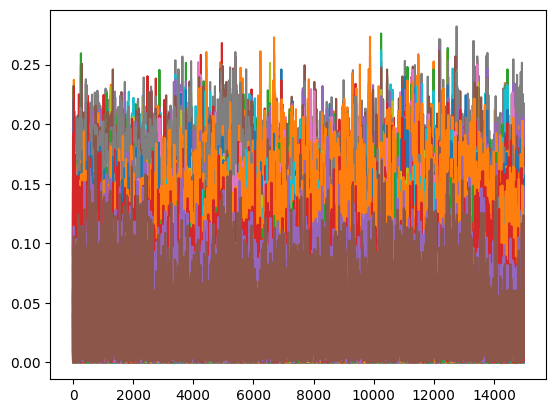

In [ ]:
import pandas as pd
norm = pd.DataFrame(ncorr_all)
norm.to_csv("corr_all.csv")
plot_mult(np.array(ncorr_all), type = "norm")


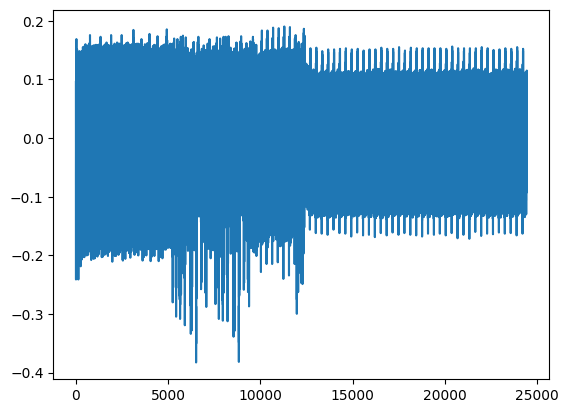

In [46]:
import matplotlib.pylab as plt
plt.plot(waves[0])

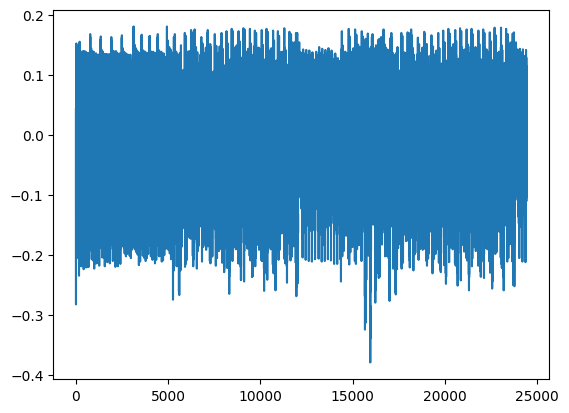

In [13]:
import matplotlib.pylab as plt
plt.plot(waves[0])

In [10]:
cw.plot(waves[0])

:Curve   [x]   (y)

In [54]:
cw_setuper._scope_disc_()

✔️ Firmware disconnected.


In [90]:
thousand_mult = waves[0]

In [91]:
cw.plot(tenthousand_mult) * cw.plot(thousand_mult)

:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)

In [92]:
cw.plot(tenthousand_mult - thousand_mult)

:Curve   [x]   (y)

In [82]:
cw.plot(tenthousand_mult) * cw.plot(none_mult)

:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)

In [83]:
cw.plot(tenthousand_mult - none_mult)

:Curve   [x]   (y)

In [81]:
none_mult = waves[0]

In [71]:
tenthousand_mult = waves[0]

In [93]:
cw_setuper._scope_disc_()

✔️ Firmware disconnected.
